In [55]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
import snowFun
# %matplotlib widget

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")

In [2]:
# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
rgi_gdf = gpd.read_file(path_rgi)

Wolverine RGIId: RGI60-01.09162
Gulkana RGIId: RGI60-01.00570

In [3]:
# subset rgi to single outline, by choosing rgiid or rgi name
rgiid = "RGI60-01.09162"
rginame = 0

# get the rgi id for the given glacier name, if a name has been given
if rginame:
    rgiid = rgi_gdf[rgi_gdf['Name']==rginame]['RGIId'].values[0]

# grab just this rgi geometry and info
rgi_single = rgi_gdf[rgi_gdf['RGIId']==rgiid].to_crs("EPSG:3338")
single_geometry = rgi_single.geometry

# single_geometry = single_geometry.buffer(-100) #what if we buffer out the exterior 100 meters of the glacier

everything loaded


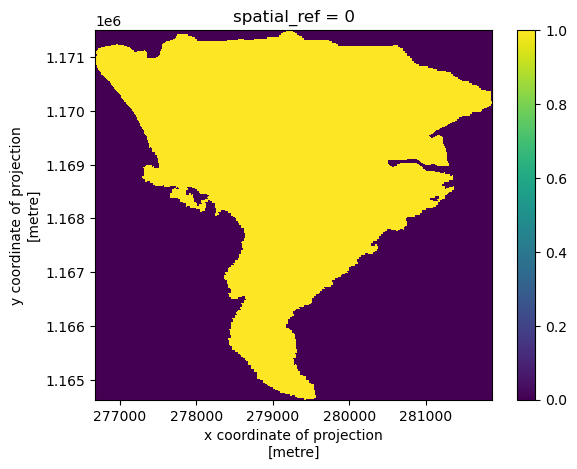

In [4]:
# open the glacier classification, clipping to the glacier outline
file_name = f"S2_{rgiid}_2018-01-01_2023-01-01"
xr_class = riox.open_rasterio(os.path.join(folder_class, f"{file_name}.tif")).rio.clip(single_geometry, from_disk=True, drop=True)

# load metadata csv, convert date to datetimes
meta_fp = os.path.join(folder_meta, f"{file_name}.csv")
meta_df = pd.read_csv(meta_fp)

# format time axis to pandas datetime, like xarray wants
datetimes = pd.to_datetime([f"{str(i)[:4]}-{str(i)[4:6]}-{str(i)[6:]}" for i in meta_df['date']])
xr_class = xr_class.rename({"band":"time"})
xr_class['time'] = datetimes

# create quick binary glacier mask of 0 and 1
glacier_mask = xr_class.max(dim='time')
glacier_mask = (glacier_mask>0)#.astype(int)

# merge images on same day
xr_class = xr_class.where(xr_class<20, 0).groupby('time').max('time')

# get these merged dates
datetimes_merged = xr_class.time.values

# get base dem of the glacier
xr_dem = snowFun.get_base_DEM(single_geometry.values[0])

print("everything loaded")
# testing not using cloud masking
# xr_cloud = xr.where(xr_cloud>0,1,xr_cloud)

# quick image showing the glacier mask
glacier_mask.plot()


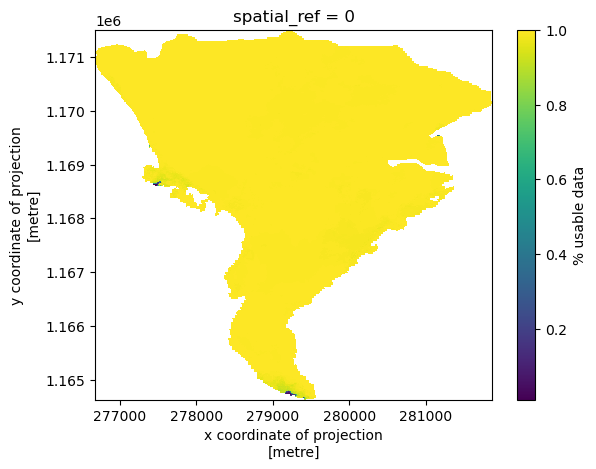

In [5]:
### create binary mask of useable and unuseable data
bad_classes = [5] #class 5 is shadow. we will call these area unusable
good_classes = [1,2,3,4,6] #snow,firn,ice,debris,water are usable areas
usable = xr.where( xr_class.isin(good_classes), 1, 0)

# count total number of pixels on the glacier surface
glacier_pixels = glacier_mask.sum().values

# count usable pixels on each day
count_usable_by_time = usable.sum(dim=['x','y']) 

# calculate percent of the glacier surface that is usable on each day
percent_usable_by_time = count_usable_by_time/glacier_pixels

# count number of total observations at each pixel (usable and not usable)
count_total_by_pixel = xr.where( xr_class>0, 1, 0).sum('time')

# count number of usable observations at each pixel
count_usable_by_pixel = usable.sum(dim='time') 

# calculate the percentage of observations that are usable, at each pixel
percent_usable_by_pixel = count_usable_by_pixel/count_total_by_pixel # sum and divide by number of obs

# we will define the "good days", aka days where at least x% of the glacier surface was observed
# we will usually remove any other days before we apply any analysis
good_times = (percent_usable_by_time>0.1)

# now we can mask out unusable areas in each time step
# and then forward fill in the gaps using the most recent usable observation
xr_class_masked = xr.where(usable==1, xr_class, np.nan).sel(time=good_times) # note we subset to only the good days

# quick image showing percent_usable_by_pixel. this should be almost al 
fig,axs=plt.subplots()
percent_usable_by_pixel.plot(ax=axs, cbar_kwargs={"label": "% usable data"})

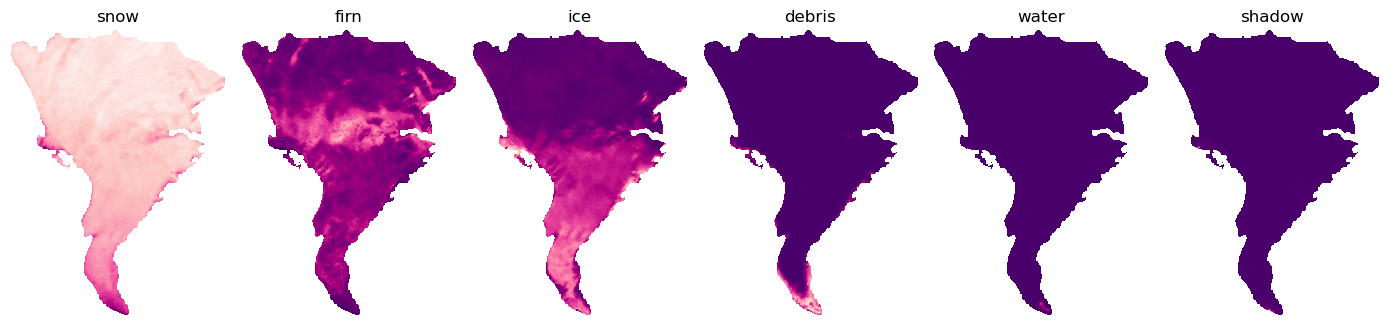

In [6]:
### make a figure showing the frequency of each data type
titles = ['snow', 'firn', 'ice', 'debris', 'water', 'shadow']
cmap='RdPu_r'

fig,axs = plt.subplots(1,6, figsize=(14,4))
axs[0].imshow( xr.where(xr_class_masked==1, 1, 0).sum(dim=['time']) * percent_usable_by_pixel, cmap=cmap)#, vmin=0, vmax=100)
axs[1].imshow( xr.where(xr_class_masked==2, 1, 0).sum(dim=['time']) * percent_usable_by_pixel, cmap=cmap)#, vmin=0, vmax=100)
axs[2].imshow( xr.where(xr_class_masked==3, 1, 0).sum(dim=['time']) * percent_usable_by_pixel, cmap=cmap)#, vmin=0, vmax=100)
axs[3].imshow( xr.where(xr_class_masked==4, 1, 0).sum(dim=['time']) * percent_usable_by_pixel, cmap=cmap)#, vmin=0, vmax=100)
axs[4].imshow( xr.where(xr_class_masked==6, 1, 0).sum(dim=['time']) * percent_usable_by_pixel, cmap=cmap)#, vmin=0, vmax=100)
axs[5].imshow( xr.where(xr_class       ==5, 1, 0).sum(dim=['time'])/glacier_mask, cmap=cmap)

for i in range(len(titles)):
    ax=axs[i]
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()

# Let's test a few methods of creating a gap-filled snow cover product

### First approach is just forward-filling the nans

In [7]:
snow1 = xr_class_masked.ffill(dim='time')
snow1 = xr.where(snow1==1, 1, 0)

### Second approach: calculate snow using moving-window smoothing, but don't fill in any remaining missing values

In [59]:
# create raw snow product where snow=1, other class=0, cloud=np.nan
snow_masked = xr.where(xr_class_masked.isin([2,3,4,6]), 0, xr_class_masked)

# Create a new empty dataarray with the same x/y shape, but with 1-day frequency
time_values = pd.to_datetime(snow_masked.time.values)
new_time_values = pd.date_range(start=time_values.min(), end=time_values.max(), freq='D')
snow2 = xr.DataArray(0, coords={'time': new_time_values, 'y': snow_masked.y, 'x': snow_masked.x },
                              dims=('time', 'y', 'x'))

# Update the new DataArray with available data from the original DataArray
snow2 = snow_masked.broadcast_like(snow2)

# now use rolling window mean and then extract the original good obs
snow2 = (snow2.rolling(time=15, min_periods=1, center=False).mean(skipna=False)).loc[dict(time=time_values)]

### make the floats to 0s and 1s, but preserve nans
snow2 = xr.where(snow2>=0.5, 1, snow2)
snow2 = xr.where(snow2<0.5, 0, snow2)

### Third attempt: keep original classification data, but fill in missing data with with the smoothed data from the second approach

In [60]:
snow3 = snow_masked.fillna(snow2)

## lets see some figures comparing our results

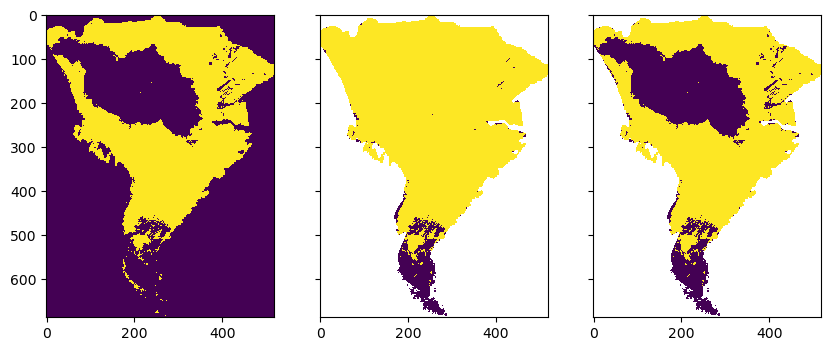

In [61]:
# figure showing snow at a single timestep
t=79
fig,axs = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axs[0].imshow(snow1.isel(time=t), vmin=0, vmax=1, interpolation='none' )
axs[1].imshow(snow2.isel(time=t), vmin=0, vmax=1, interpolation='none' )
axs[2].imshow(snow3.isel(time=t), vmin=0, vmax=1, interpolation='none' )

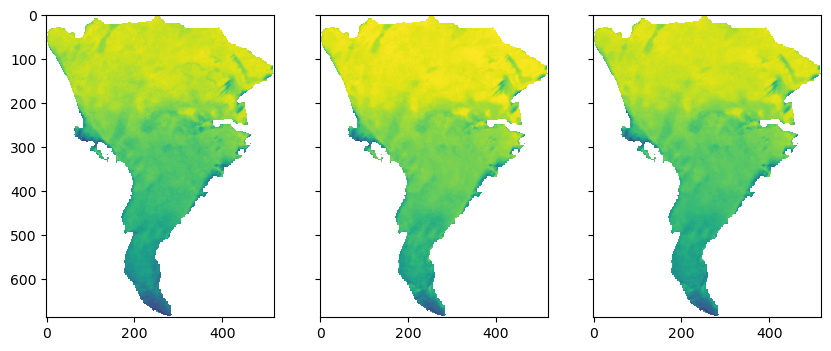

In [62]:
# figure showing the frequency of snow in each
fig,axs = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axs[0].imshow(snow1.mean('time', skipna=True)/glacier_mask, vmin=0, vmax=1)
axs[1].imshow(snow2.mean('time', skipna=True)/glacier_mask, vmin=0, vmax=1)
axs[2].imshow(snow3.mean('time', skipna=True)/glacier_mask, vmin=0, vmax=1)

Text(0, 0.5, 'AAR')

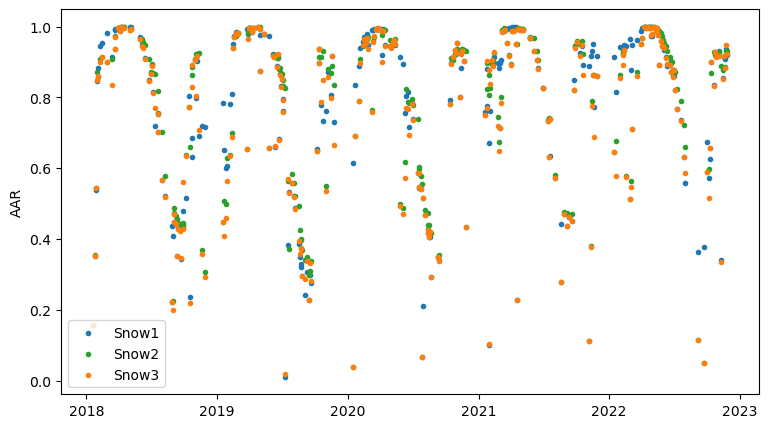

In [63]:
# figure plotting the timeseries of snow cover in each product
fig, axs = plt.subplots(figsize=(9,5))
axs.scatter(snow1.time, snow1.sum(dim=['x','y'], skipna=True)/glacier_pixels, c='tab:blue', marker=".", label='Snow1')
axs.scatter(snow1.time, snow2.sum(dim=['x','y'], skipna=True)/glacier_pixels, c='tab:green', marker=".", label='Snow2')
axs.scatter(snow1.time, snow3.sum(dim=['x','y'], skipna=True)/glacier_pixels, c='tab:orange', marker=".", label='Snow3')
axs.legend(loc="lower left")
axs.set_ylabel("AAR")

In [65]:
# now choose which of these products to use from here forward
snow = snow2

In [66]:
### smooth a little bit using some convolution
snow_x = snow.rolling({'x':3}, min_periods=1, center=True).sum()
snow_x = snow_x.rolling({'y':3}, min_periods=1, center=True).sum()
norm_x = (snow>-1).rolling({'x':3}, min_periods=1, center=True).sum()
norm_x = norm_x.rolling({'y':3}, min_periods=1, center=True).sum()

snow_x = snow_x/norm_x # this show what fraction of the 3x3 box around each pixel is snow
snow_x = xr.where(snow_x>=0.5, 1, snow_x)
snow_x = xr.where(snow_x<0.5, 0, snow_x)
snow_x = xr.where(glacier_mask==1, snow_x, np.nan)

snow = snow_x

# we need to recount the pixels in each image, how much is observable, etc...
count_snow_by_time = snow.sum(dim=['x','y'], skipna=True) # total snow obs in each time
count_all_by_time = xr.where(snow>-1,1,0).sum(dim=['x','y'])
percent_all_by_time = count_all_by_time/glacier_pixels
percent_snow_by_time = count_snow_by_time/count_all_by_time

In [67]:
# filter out the dates that have less than x% usable data
usable_thresh = 0.85
snow = snow.sel(time=(percent_all_by_time>usable_thresh))

In [68]:
# extract ELAs from each time step
glacier_ELAs = snowFun.get_the_ELAs(snow, xr_dem, glacier_mask, step=20, width=1, p_snow=0.5)

# lets add aar on to the df as well
glacier_ELAs['aar'] = percent_snow_by_time.sel(time=(percent_all_by_time>usable_thresh))

In [69]:
# if ela is above the glacier then we get 9999. below and we get -1
# we can change these to the glacier min or max if we want (buffered by 1)
z_min = np.nanmin(xr_dem.where(xr_dem>0))
z_max = np.nanmax(xr_dem)
glacier_ELAs = glacier_ELAs.replace({'ela': {-1:z_min, 9999:z_max} })

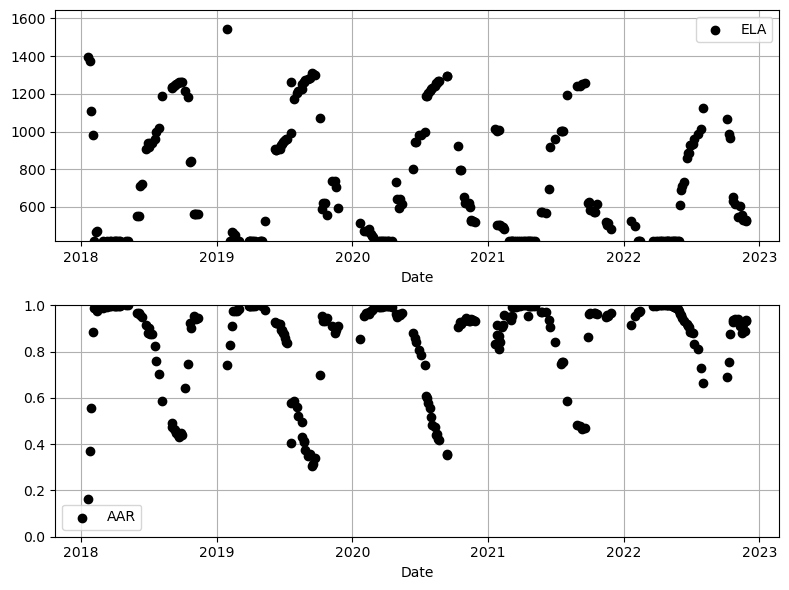

In [70]:
# figure plotting ela and aar timeseries
fig,axs=plt.subplots(2,1, figsize=(8,6))

axs[0].scatter(glacier_ELAs['time'], glacier_ELAs['ela'], c='black', zorder=2, label='ELA')
axs[1].scatter(glacier_ELAs['time'], glacier_ELAs['aar'], c='black', zorder=2, label='AAR')

for ax in axs:
    ax.grid(zorder=1)
    ax.set_xlabel('Date')
    ax.legend()
    
axs[0].set_ylim(z_min,z_max)
axs[1].set_ylim(0,1)
   
# fig.autofmt_xdate()
plt.tight_layout()

(0.0, 1.0)

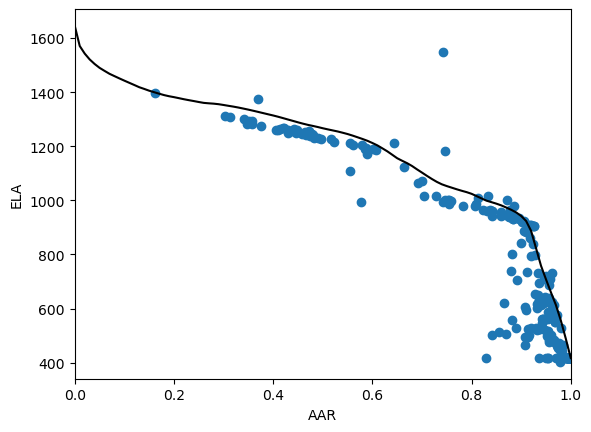

In [71]:
### figure plotting ELA against AAR to view relationship
ideal_ELAs = snowFun.idealized_ELA_AAR(xr_dem, glacier_mask)

fig, axs = plt.subplots()
axs.scatter(glacier_ELAs['aar'], glacier_ELAs['ela'])
axs.plot(ideal_ELAs['aar'], ideal_ELAs['ela'], c='black')
axs.set_xlabel('AAR')
axs.set_ylabel('ELA') 
axs.set_xlim(0,1)

(0.0, 1.0)

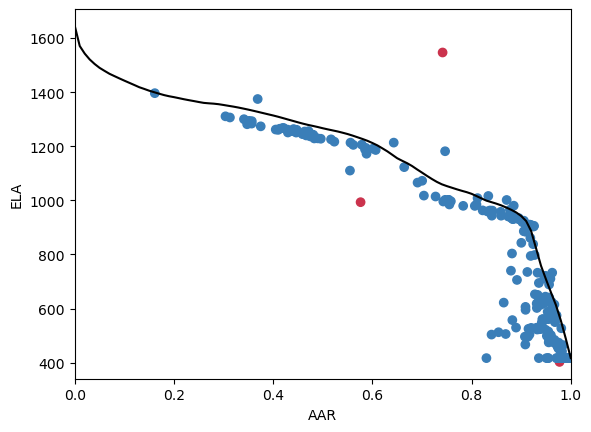

In [72]:
# lets use this aar-ela relationship to root out bad observations
# for each aar we observed, see what the ideal ela would be
glacier_ELAs['aar_round'] = glacier_ELAs['aar'].round(2)
glacier_ELAs['ela_ideal'] = [ ideal_ELAs[ideal_ELAs['aar'].round(2)==i]['ela'].values[0] for i in glacier_ELAs['aar_round'] ]

# how about we incorporate a little error and see the range of elas we could expect
error_allowed = 0.2
glacier_ELAs['ela_ideal_min'] = [ ideal_ELAs[ideal_ELAs['aar'].round(2)==round(min(i+error_allowed,1),2)]['ela'].values[0] for i in glacier_ELAs['aar_round'] ]
glacier_ELAs['ela_ideal_max'] = [ ideal_ELAs[ideal_ELAs['aar'].round(2)==round(max(i-error_allowed,0),2)]['ela'].values[0] for i in glacier_ELAs['aar_round'] ]
glacier_ELAs['quality'] = [1 if (row['ela_ideal_min'] <= row['ela'] <= row['ela_ideal_max']) else 0 for idx,row in glacier_ELAs.iterrows()]

# now lets plot ela-aar relationship again, coloring by whether the observations fall within expected range    
fig, axs = plt.subplots()
axs.scatter(glacier_ELAs['aar'], glacier_ELAs['ela'], c=glacier_ELAs['quality'], cmap='Spectral', vmin=-0.1, vmax=1.1)
axs.plot(ideal_ELAs['aar'], ideal_ELAs['ela'], c='black')
axs.set_xlabel('AAR')
axs.set_ylabel('ELA') 
axs.set_xlim(0,1)

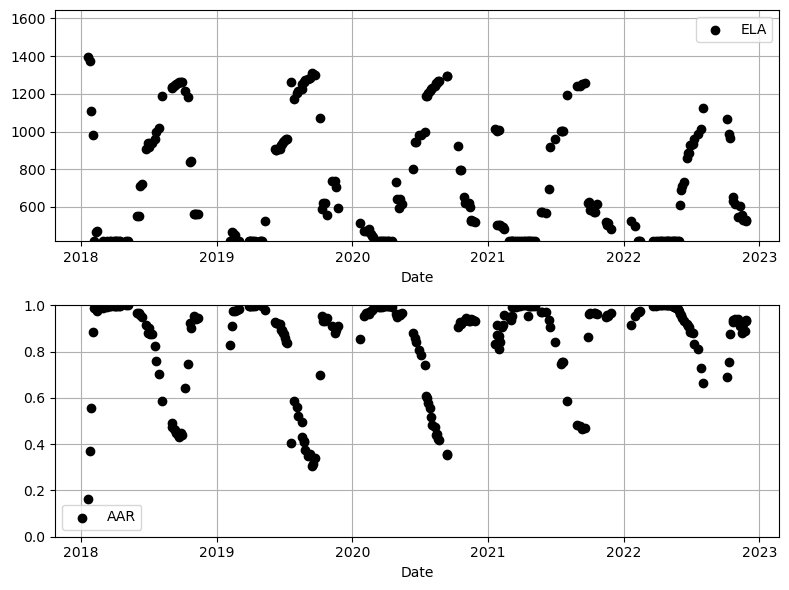

In [73]:
# plot the timeseries of the "good" elas
fig,axs=plt.subplots(2,1, figsize=(8,6))

axs[0].scatter(glacier_ELAs[glacier_ELAs['quality']==1]['time'], glacier_ELAs[glacier_ELAs['quality']==1]['ela'], c='black', zorder=2, label='ELA')
axs[1].scatter(glacier_ELAs[glacier_ELAs['quality']==1]['time'], glacier_ELAs[glacier_ELAs['quality']==1]['aar'], c='black', zorder=2, label='AAR')

for ax in axs:
    ax.grid(zorder=1)
    ax.set_xlabel('Date')
    ax.legend()

axs[0].set_ylim(z_min,z_max)
axs[1].set_ylim(0,1)

# fig.autofmt_xdate()
plt.tight_layout()

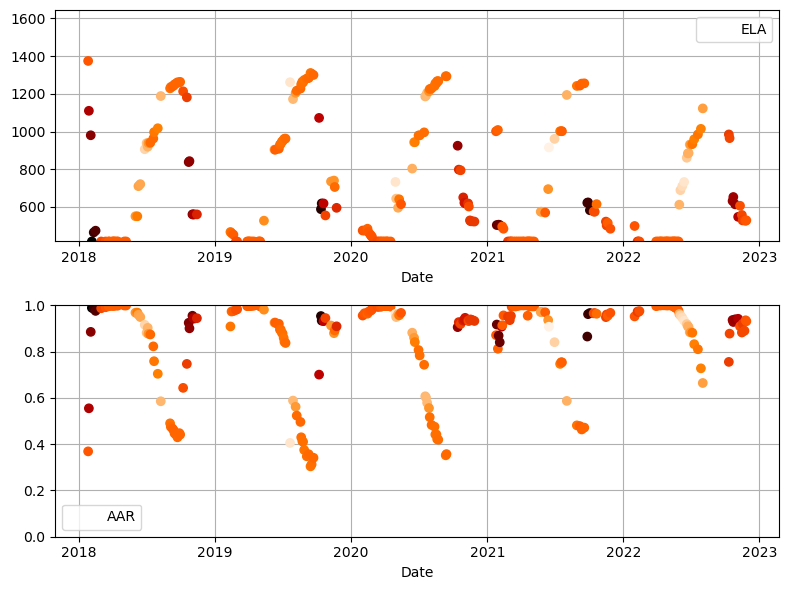

In [74]:
### get rolling median of quality ela obs in prior x days
x_days = 30

# define function to do this
def get_rolling_median(df_obs, col_name, n_days, min_periods=1, center=False, closed='left'):
    temp_df = df_obs[['time',col_name]].set_index('time')
    medians = temp_df.rolling(f'{n_days}D', min_periods=min_periods, center=center, closed=closed).median()
    return medians

# subset df to good obs
glacier_ELAs_good = glacier_ELAs[glacier_ELAs['quality']==1].copy()
test = get_rolling_median(glacier_ELAs_good, 'ela', x_days, center=False)
glacier_ELAs_good['ela_rolling'] = test.values
glacier_ELAs_good['ela_diff'] = glacier_ELAs_good['ela']-glacier_ELAs_good['ela_rolling']


# plot and color by difference from median rolling aar
fig,axs=plt.subplots(2,1, figsize=(8,6))

axs[0].scatter(glacier_ELAs_good['time'], glacier_ELAs_good['ela'], c=glacier_ELAs_good['ela_diff'], cmap='gist_heat', zorder=2, label='ELA')
axs[1].scatter(glacier_ELAs_good['time'], glacier_ELAs_good['aar'], c=glacier_ELAs_good['ela_diff'], cmap='gist_heat', zorder=2, label='AAR')

for ax in axs:
    ax.grid(zorder=1)
    ax.set_xlabel('Date')
    ax.legend()

axs[0].set_ylim(z_min,z_max)
axs[1].set_ylim(0,1)

# fig.autofmt_xdate()
plt.tight_layout()

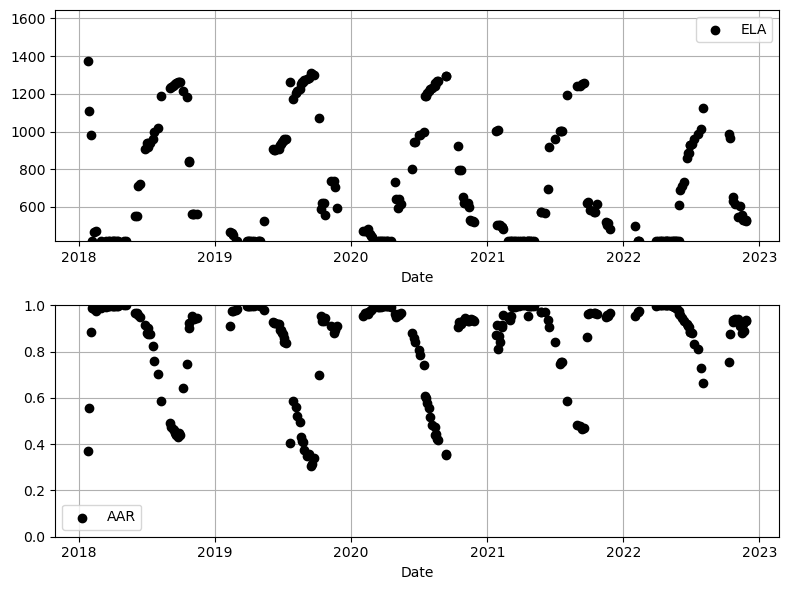

In [75]:
# lets say that an ela that is 400 or more meter above the rolling median is bad
new_df = glacier_ELAs_good[glacier_ELAs_good['ela_diff']<400]

fig,axs=plt.subplots(2,1, figsize=(8,6))

axs[0].scatter(new_df['time'], new_df['ela'], c='black', zorder=2, label='ELA')
axs[1].scatter(new_df['time'], new_df['aar'], c='black', zorder=2, label='AAR')

for ax in axs:
    ax.grid(zorder=1)
    ax.set_xlabel('Date')
    ax.legend()

axs[0].set_ylim(z_min,z_max)
axs[1].set_ylim(0,1)

# fig.autofmt_xdate()
plt.tight_layout()

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


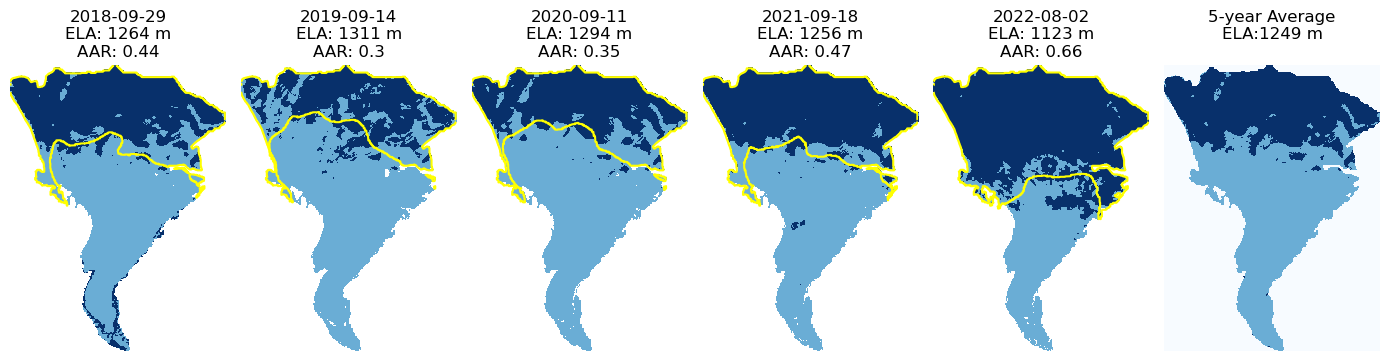

In [85]:
# so now from this, lets extract the snow distribution at the end of each year
df = new_df.copy()
df['time_index'] = df['time']
df = df.set_index('time_index')

ys = [2018,2019,2020,2021,2022]
target = 'ela'
data = []
for y in ys:

    # subset df to this year
    df_subset = df.loc[f'{y}-07-01':f'{y}-11-01']
    
    # get the row that has max ela within this time frame
    idx = df_subset[target].idxmax()
    ela_max = df_subset.loc[idx]
    
    data.append(ela_max)

max_elas = pd.DataFrame(data)
median_ela = np.nanmean(max_elas[target])

# now go through and grab the snow distributions for these dates, plot them all
all_maps = []
fig, axs = plt.subplots(1,len(ys)+1, figsize=(14,4))
for d in range(len(data)):
    ax = axs[d]
    series = data[d]
    snow_map = snow.sel(time=series['time'].to_pydatetime())
    all_maps.append(snow_map)
    
    ax.imshow(snow_map/glacier_mask, cmap='Blues', vmin=-1, vmax=1, interpolation='none')
    ax.axis('off')
    ax.set_title(f"{series['time'].strftime('%Y-%m-%d')}\nELA: {round(series['ela'])} m\nAAR: {round(series['aar'],2)}")
    
    # lets also contour the chosen ela on the glacier too
    ax.contour(xr_dem[0,:,:], levels=[round(series[target])], colors=['yellow'])

# concat the end of summer obs into a single xr_da, calculate a single average snow cover map
all_maps = xr.concat(all_maps, dim='time')
average_map = all_maps.median('time', skipna=True).astype('uint8')+glacier_mask

axs[-1].imshow(average_map, cmap='Blues', vmin=0, vmax=2, interpolation='none')
axs[-1].axis('off')
axs[-1].set_title(f"5-year Average\nELA:{round(median_ela)} m\n")

plt.tight_layout()

In [96]:
### save products to file

# set folder paths, etc...
folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')
path_df_all = os.path.join(folder_save, 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
path_xr_all = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_2018_2022_annual_AAs.nc")
path_xr_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.nc")
path_tif_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.tif")

### save csv
save_df = pd.DataFrame(data) # table with annual end-of-summer ela, aar, 
save_df.to_csv(path_df_all, index=False, columns=['time','ela','aar'])

### save the annual AA product, average AA as netcdf
# format metadata and attributes
def format_xr_to_save(xr_da):
    xr_da.attrs["res"] = (10,10)
    xr_da.attrs["crs"] = "EPSG:3338"
    xr_da.attrs["transform"] = [10,0,0,0,-10,0]
    xr_da.attrs["_FillValue"] = 0
    xr_da.attrs["long_name"] = rgiid
    xr_da.attrs["description"] = "0: nan, 1: ablation, 2: accumulation"
    xr_da.name = "accumulation_area"
    
    xr_da.x.attrs["units"] = "meters"
    xr_da.y.attrs["units"] = "meters"
    xr_da.x.attrs["long_name"] = 'x'
    xr_da.y.attrs["long_name"] = 'y'
    
#     xr_da.rio.write_crs(3338, inplace=True)
    
    return xr_da

save_xr_all = format_xr_to_save(all_maps.astype('uint8')+glacier_mask)
save_xr_avg = format_xr_to_save(average_map)
save_tif_avg = save_xr_avg.values

# specify compression/encoding
encoding = {"accumulation_area":{"zlib": True}}#, "spatial_ref":{"zlib": False}}

# save
save_xr_all.to_netcdf(path_xr_all, encoding=encoding)
save_xr_avg.to_netcdf(path_xr_avg, encoding=encoding)

### save average AA as geotiff
from rasterio.transform import from_origin
transform = from_origin(save_xr_avg.x.values[0]-5,
                        save_xr_avg.y.values[0]+5,
                        save_xr_avg.x.values[1] - save_xr_avg.x.values[0],
                        save_xr_avg.y.values[0] - save_xr_avg.y.values[1])

with rio.open(path_tif_avg, 'w', driver='GTiff', height=save_tif_avg.shape[0], width=save_tif_avg.shape[1],
                   count=1, dtype=str(save_tif_avg.dtype), crs="EPSG:3338", transform=transform, compress='ZSTD') as dst:
    dst.write(save_tif_avg, 1)


# print(save_xr_all.variables.keys())
print(save_xr_all.dtype)

uint8


C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\xarray\core\duck_array_ops.py:187: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
